In [8]:
%pylab inline
import dask.dataframe as dd
import pandas as pd
import numpy as np
import fastparquet

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_text(fin):
    numprops = pd.read_csv(fin,sep=' ',skiprows=1,nrows=1,header=None)[0][0]
    head = pd.read_csv(fin,sep=' ',skiprows=2,nrows=numprops,header=None)
    df = dd.read_csv(fin,
                     sep=' ',header=numprops+1,na_values=-999,
                    names=list(head[0])+['null']
    )
    df = df.repartition(npartitions=60).drop('null',1)
    return df

In [10]:
fin = '/scratch/Haynesville_petrel/Attributes around midpoint.txt'
df = read_text(fin)
df.to_parquet('/scratch/Haynesville_petrel/parq')
df = dd.read_parquet('/scratch/Haynesville_petrel/parq')

print(df.columns,'\n',len(df)/1e6,'million rows')

In [58]:
UWI = pd.read_excel('/scratch/Haynesville_petrel/UWI-index.xlsx',converters={'Well identifier':str})
print(UWI.head())
len(UWI)


  Well identifier  UWI-index
0  17013218210100          1
1  17013218530000          2
2  17013218620000          3
3  17013219080000          4
4  17013219090000          5


3684

In [12]:
df_midpoints = df.dropna(subset=['UWI-index']).compute()
df_midpoints.to_pickle('/scratch/Haynesville_petrel/midpoints.pkl')
#df_midpoints = pd.read_pickle('WestTexas/midpoint_cells.pkl')
print(len(df_midpoints))

3526


In [19]:
x = UWI[~UWI['UWI-index'].isin(df_midpoints['UWI-index'])]
print(len(x),'wells have no cell assigned')
x.to_csv('/scratch/Haynesville_petrel/UWI_nocell.csv')

158 wells have no cell assigned


'\nfigure()\nsns.countplot((df_midpoints.Mainzones.astype(int)+1).replace(long_layerdict))\nxticks(rotation=90)\n'

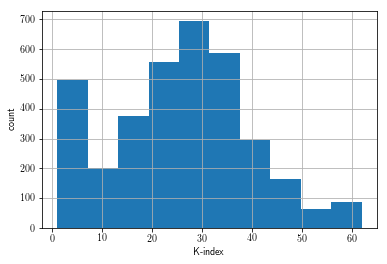

In [20]:
import seaborn as sns
df_midpoints.k_index.hist()
xlabel('K-index')
ylabel('count')
"""
figure()
sns.countplot((df_midpoints.Mainzones.astype(int)+1).replace(long_layerdict))
xticks(rotation=90)
"""

In [80]:
def filter_cells(df,df_midpoints):
    df_ij_big = df[(df['i_index'].isin(df_midpoints['i_index'])) & 
                  df['j_index'].isin(df_midpoints['j_index'])]
    
    df_ij = (df_ij_big.compute()
             .dropna(thresh=3)
             .set_index(['i_index','j_index','k_index'])
             .sort_index()
             .loc[idx[df_midpoints['i_index'],df_midpoints['j_index'],:],]
             )
    return df_ij

def agg_cells(df_ij,df_midpoints,attrs):
    df_ave = pd.DataFrame(index=df_midpoints['UWI-index'].unique())
    for _,w in df_midpoints.iterrows():
        try:
            cells = df_ij.loc[idx[w['i_index'],w['j_index'],:],]
        except KeyError as e:
            print(e)
            continue
        for attr in attrs:
            for aggfunc in ['mean','median']:
                column = attr+'_'+aggfunc+'_50around'
                df_ave.loc[w['UWI-index'],column] = (cells
                                                     .loc[abs(cells['z_coord']-w['z_coord'])<=50,attr]
                                                     .agg(aggfunc)
                                                    )
                column = attr+'_'+aggfunc+'_25-75above'
                df_ave.loc[w['UWI-index'],column] = (cells
                                                     .loc[abs(cells['z_coord']-w['z_coord']+50)<=25,attr]
                                                     .agg(aggfunc)
                                                    )
    return df_ave

def assign_UWI(df_ave,UWI,UWI_attr='Well identifier'):
    df_ave['UWI']=(df_ave.index
               .to_series()
               .to_frame()
               .join(UWI)
               [UWI_attr]
              )
    return df_ave

In [87]:
fin = '/scratch/Fayetteville_petrel/Attributes around midpoint.txt'
df = read_text(fin)
df.to_parquet('/scratch/Fayetteville_petrel/parq')
df = dd.read_parquet('/scratch/Fayetteville_petrel/parq')

print(df.columns)
print(len(df)/1e6,'million cells in original model')

df_midpoints = df.dropna(subset=['UWI-index']).compute()
df_midpoints.to_pickle('/scratch/Fayetteville_petrel/midpoints.pkl')
print(len(df_midpoints),'wells have a cell assigned')

UWI = pd.read_excel('/scratch/Fayetteville_petrel/UWI-index.xlsx',converters={'UWI':str})
#print(UWI.head(),'\n')
print(len(UWI),'wells have UWIs')

x = UWI[~UWI['UWI-index'].isin(df_midpoints['UWI-index'])]
print(len(x),'wells have no cell assigned')
x.to_csv('/scratch/Fayetteville_petrel/UWI_nocell.csv')

df_ij = filter_cells(df,df_midpoints)
print(len(df_ij),'cells left after filtering')

df_ave = agg_cells(df_ij,df_midpoints,['PhiT_New','PhiSep'])
df_ave = assign_UWI(df_ave,UWI,'UWI')

df_ave.to_excel('../Fayetteville_data/attributes_around_midpoints_Fayetteville.xlsx')
df_ave.describe()

Index(['i_index', 'j_index', 'k_index', 'x_coord', 'y_coord', 'z_coord',
       'Layers', 'PhiT_New', 'PhiSep', 'UWI-index'],
      dtype='object')
1.164964 million cells in original model
4919 wells have a cell assigned
5591 wells have UWIs
672 wells have no cell assigned
866189 cells left after filtering


,PhiT_New_mean_50around,PhiT_New_mean_25-75above,PhiT_New_median_50around,PhiT_New_median_25-75above,PhiSep_mean_50around,PhiSep_mean_25-75above,PhiSep_median_50around,PhiSep_median_25-75above
count,4919.000000,4776.000000,4919.000000,4776.000000,4919.000000,4776.000000,4919.000000,4776.000000
mean,0.081767,0.082023,0.081678,0.082106,0.113869,0.120841,0.111942,0.120972
std,0.005887,0.006315,0.005991,0.006312,0.023088,0.025010,0.026075,0.025902
min,0.059710,0.052169,0.058120,0.047671,0.026998,0.016737,0.007375,0.006924
25%,0.077546,0.077928,0.077509,0.078119,0.099877,0.103120,0.094964,0.102971
50%,0.081805,0.082022,0.081707,0.082048,0.112496,0.121557,0.111203,0.122043
75%,0.085612,0.085834,0.085624,0.085868,0.128103,0.137711,0.128690,0.138773
max,0.107173,0.107693,0.103693,0.111565,0.230019,0.220222,0.242638,0.220222


In [88]:
df_ave_fay = df_ave.copy()
df_ave_fay.head()

,PhiT_New_mean_50around,PhiT_New_mean_25-75above,PhiT_New_median_50around,PhiT_New_median_25-75above,PhiSep_mean_50around,PhiSep_mean_25-75above,PhiSep_median_50around,PhiSep_median_25-75above,UWI
5133.0,0.078593,NaN,0.078402,NaN,0.064969,NaN,0.063307,NaN,03145110050000
2461.0,0.074760,NaN,0.075830,NaN,0.142900,NaN,0.143699,NaN,03045104290000
5334.0,0.079417,NaN,0.079408,NaN,0.116601,NaN,0.116438,NaN,03145112270000
4471.0,0.082420,NaN,0.082487,NaN,0.101949,NaN,0.097227,NaN,03145102510000
1463.0,0.073643,NaN,0.071596,NaN,0.134672,NaN,0.137442,NaN,03029106170000


In [84]:
fin = '/scratch/Haynesville_petrel/Attributes around midpoint.txt'
df = read_text(fin)
df.to_parquet('/scratch/Haynesville_petrel/parq')
df = dd.read_parquet('/scratch/Haynesville_petrel/parq')

print(df.columns)
print(len(df)/1e6,'million cells in original model')

df_midpoints = df.dropna(subset=['UWI-index']).compute()
df_midpoints.to_pickle('/scratch/Haynesville_petrel/midpoints.pkl')
print(len(df_midpoints),'wells have a cell assigned')

UWI = pd.read_excel('/scratch/Haynesville_petrel/UWI-index.xlsx',converters={'Well identifier':str})
#print(UWI.head(),'\n')
print(len(UWI),'wells have UWIs')

x = UWI[~UWI['UWI-index'].isin(df_midpoints['UWI-index'])]
print(len(x),'wells have no cell assigned')
x.to_csv('/scratch/Haynesville_petrel/UWI_nocell.csv')

df_ij = filter_cells(df,df_midpoints)
print(len(df_ij),'cells left after filtering')

df_ave = agg_cells(df_ij,df_midpoints,['DPHI_CALIB','PHISEP'])
df_ave = assign_UWI(df_ave,UWI,'Well identifier')
df_ave.to_excel('../Haynesville_data/attributes_around_midpoints.xlsx')

df_ave.describe()

Index(['i_index', 'j_index', 'k_index', 'x_coord', 'y_coord', 'z_coord',
       'DPHI_CALIB', 'PHISEP', 'UWI-index'],
      dtype='object')
13.909654 million cells in original model
3526 wells have a cell assigned
3684 wells have UWIs
158 wells have no cell assigned
10513490 cells left after filtering


,DPHI_CALIB_mean_50around,DPHI_CALIB_mean_25-75above,DPHI_CALIB_median_50around,DPHI_CALIB_median_25-75above,PHISEP_mean_50around,PHISEP_mean_25-75above,PHISEP_median_50around,PHISEP_median_25-75above
count,3065.000000,3012.000000,3065.000000,3012.000000,3065.000000,3012.000000,3065.000000,3012.000000
mean,0.079988,0.078116,0.080766,0.078977,0.031623,-0.017367,0.036059,0.014812
std,0.008183,0.010042,0.008189,0.010034,0.054548,0.516431,0.016668,0.480677
min,0.043540,0.023300,0.041217,0.023300,-1.599709,-22.970860,-0.018505,-22.970860
25%,0.074863,0.073447,0.075846,0.074698,0.024200,0.009510,0.025489,0.021545
50%,0.080782,0.079060,0.081591,0.080494,0.032273,0.028229,0.031210,0.030578
75%,0.085854,0.084662,0.086502,0.085728,0.045814,0.038379,0.045647,0.041349
max,0.110636,0.110376,0.109502,0.108192,0.129685,0.095910,0.141967,0.104702


In [86]:
df_ave_hay = df_ave.copy()

In [24]:
df_ij_big = (df[(df['i_index'].isin(df_midpoints['i_index'])) & 
              df['j_index'].isin(df_midpoints['j_index'])]
             #.dropna(thresh=3)
           )
print(len(df_ij_big)/1e6,'million cells')
#df_ij_big.to_parquet("/scratch/JulyMidland/")

In [32]:
df_ij = (df_ij_big.compute()
         .dropna(thresh=3)
         .set_index(['i_index','j_index','k_index'])
        .sort_index()
        .loc[idx[df_midpoints['i_index'],df_midpoints['j_index'],:],]
        )

In [ ]:
df_ave = pd.DataFrame(index=df_midpoints['UWI-index'].unique())
for _,w in df_midpoints.iterrows():
    cells = df_ij.loc[idx[w['i_index'],w['j_index'],:],]
    for attr in ['DPHI_CALIB','PHISEP']:
        for aggfunc in ['mean','median']:
            column = attr+'_'+aggfunc+'_50around'
            df_ave.loc[w['UWI-index'],column] = (cells
                                                 .loc[abs(cells['z_coord']-w['z_coord'])<=50,attr]
                                                 .agg(aggfunc)
                                                )
            column = attr+'_'+aggfunc+'_25-75above'
            df_ave.loc[w['UWI-index'],column] = (cells
                                                 .loc[abs(cells['z_coord']-w['z_coord']+50)<=25,attr]
                                                 .agg(aggfunc)
                                                )

In [59]:
df_ave['UWI']=(df_ave.index
               .to_series()
               .to_frame()
               .join(UWI)
               ['Well identifier']
              )

In [63]:
df_ave.to_excel('../Haynesville_data/phi_phisep_aroundwells.xlsx')

In [61]:
df_ave.dropna().head()

,DPHI_CALIB_mean_50around,DPHI_CALIB_mean_25-75above,DPHI_CALIB_median_50around,DPHI_CALIB_median_25-75above,PHISEP_mean_50around,PHISEP_mean_25-75above,PHISEP_median_50around,PHISEP_median_25-75above,UWI
125.0,0.093440,0.065154,0.100936,0.065154,0.039029,0.000240,0.040372,0.000240,17013221450000
1495.0,0.063899,0.028701,0.070578,0.028701,-0.066648,-0.865005,0.024943,-0.865005,17031255220000
1224.0,0.070417,0.043232,0.074086,0.043232,-0.076793,-1.158937,0.032418,-1.158937,17031252110000
2011.0,0.084260,0.059994,0.086635,0.059994,-0.018278,-0.471792,0.028401,-0.471792,17031261890000
610.0,0.078507,0.044049,0.081494,0.044049,0.005837,-0.398400,0.042036,-0.398400,17017354130000


In [62]:
df_ave.describe()

,DPHI_CALIB_mean_50around,DPHI_CALIB_mean_25-75above,DPHI_CALIB_median_50around,DPHI_CALIB_median_25-75above,PHISEP_mean_50around,PHISEP_mean_25-75above,PHISEP_median_50around,PHISEP_median_25-75above
count,3065.000000,3012.000000,3065.000000,3012.000000,3065.000000,3012.000000,3065.000000,3012.000000
mean,0.079988,0.078116,0.080766,0.078977,0.031623,-0.017367,0.036059,0.014812
std,0.008183,0.010042,0.008189,0.010034,0.054548,0.516431,0.016668,0.480677
min,0.043540,0.023300,0.041217,0.023300,-1.599709,-22.970860,-0.018505,-22.970860
25%,0.074863,0.073447,0.075846,0.074698,0.024200,0.009510,0.025489,0.021545
50%,0.080782,0.079060,0.081591,0.080494,0.032273,0.028229,0.031210,0.030578
75%,0.085854,0.084662,0.086502,0.085728,0.045814,0.038379,0.045647,0.041349
max,0.110636,0.110376,0.109502,0.108192,0.129685,0.095910,0.141967,0.104702


In [26]:
%%time
idx=pd.IndexSlice
df_ij = []
n=0
for dfp in df_ij_big.iter_row_groups():
    print(n,'row groups down')
    n+=1
    df_ij.append(
        dfp.dropna(thresh=3)
        .set_index(['i_index','j_index','k_index'])
        .sort_index()
        .loc[idx[df_midpoints['i_index'],df_midpoints['j_index'],:],])

AttributeError: 'DataFrame' object has no attribute 'iter_row_groups'

In [20]:
df_ij = pd.concat(df_ij)
df_ij.to_hdf("/scratch/Facies-Sw-UWI-indexmatched.h5",'/data')

In [28]:
df_ij=df_ij.dropna(thresh=3)

In [31]:
df_ij.to_hdf("/scratch/Facies-Sw-UWI-indexmatched.h5",'/data')

In [32]:
!du -h /scratch/Facies-Sw-UWI-indexmatched.h5

15G	/scratch/Facies-Sw-UWI-indexmatched.h5


In [30]:
df_ij.head(10)

x_coord       y_coord      z_coord  \
i_index j_index k_index                                            
72      934     672      1.295290e+06  1.090436e+06 -7334.201355   
                673      1.295290e+06  1.090436e+06 -7339.343079   
                674      1.295290e+06  1.090436e+06 -7344.484924   
                675      1.295290e+06  1.090436e+06 -7349.626709   
                676      1.295290e+06  1.090436e+06 -7354.768433   
                677      1.295290e+06  1.090436e+06 -7359.910217   
                678      1.295290e+06  1.090436e+06 -7365.052002   
                679      1.295290e+06  1.090436e+06 -7370.193787   
                680      1.295290e+06  1.090436e+06 -7375.335571   
                681      1.295290e+06  1.090436e+06 -7380.477356   

                         FACIES-indicatorkriging  SWTedit_01012017  UWI-index  
i_index j_index k_index                                                        
72      934     672                          1.0          0.583905        NaN  
                673                          1.0          0.618298        NaN  
                674                          1.0          0.588720        NaN  
                675                          1.0          0.587275        NaN  
                676                          1.0          0.547008        NaN  
                677                          1.0          0.534744        NaN  
                678                          1.0          0.528176        NaN  
                679                          1.0          0.560505        NaN  
                680                          1.0          0.585201        NaN  
                681                          1.0          0.616421        NaN

In [41]:
%%time
df_out = []

for _,(i,j,z) in df_midpoints[['i_index','j_index','z_coord']].iterrows():
    ijmatch = df_ij.loc[idx[i,j,:]]
    
    df_out.append(
        ijmatch[abs(ijmatch['z_coord']-z)<1000]
    )
    #break
df_out=pd.concat(df_out)

CPU times: user 53min 49s, sys: 8min 25s, total: 1h 2min 15s
Wall time: 1h 2min 17s


In [46]:
print(len(df_out)/1e6)
df_out.to_pickle('/scratch/Facies-Sw-UWI-indexmatched.pkl')

1.814553


In [50]:
df_out['x_index']=pd.Categorical(df_out['x_coord']).codes
df_out['y_index']=pd.Categorical(df_out['y_coord']).codes

In [52]:
df_out.describe()

,x_coord,y_coord,z_coord,FACIES-indicatorkriging,SWTedit_01012017,UWI-index,x_index,y_index
count,1.814553e+06,1.814553e+06,1.814553e+06,1.807449e+06,1.807449e+06,7753.000000,1.814553e+06,1.814553e+06
mean,1.565640e+06,7.295169e+05,-5.650488e+03,1.579591e+00,6.990384e-01,2824.329571,2.721131e+02,3.676608e+02
std,1.217664e+05,1.670312e+05,1.319497e+03,6.307970e-01,1.569517e-01,1562.662298,1.614236e+02,2.073801e+02
min,1.295290e+06,4.169360e+05,-9.069318e+03,1.000000e+00,1.052340e-01,1.000000,0.000000e+00,0.000000e+00
25%,1.452040e+06,5.826860e+05,-6.801980e+03,1.000000e+00,5.820550e-01,1432.000000,1.210000e+02,1.820000e+02
50%,1.545790e+06,7.289360e+05,-5.839134e+03,2.000000e+00,7.111820e-01,2931.000000,2.460000e+02,3.700000e+02
75%,1.664290e+06,8.451860e+05,-4.632908e+03,2.000000e+00,8.260500e-01,4154.000000,4.030000e+02,5.230000e+02
max,1.943290e+06,1.445936e+06,-1.197547e+03,3.000000e+00,9.998840e-01,5542.000000,6.100000e+02,8.550000e+02


In [53]:
df_out.to_pickle('/scratch/Facies-Sw-UWI-indexmatched.pkl')

In [59]:
%%time
df_ij = []
for _,(i,j) in df_midpoints[["i_index","j_index"]].iterrows():
    df_ij.append(
        df_ij_big[(df_ij_big['i_index']==i) &
                 (df_ij_big['j_index']==j)]
        .compute()
    )
    
df_ij = pd.concat(df_ij)

KeyboardInterrupt: 

In [53]:
len(df_ij)

413

In [19]:
df_ij_big = (df[(df['i_index'].isin(df_midpoints['i_index'])) & 
              df['j_index'].isin(df_midpoints['j_index'])]
            .compute()
           )
df_ij = []
s = len(df_i_big)
for i in range(8):
    df_i_big.iloc[i*s//8:(i+1)*s//8].to_pickle('/scratch/TORA_July2017_df_i_big-{}.pkl'.format(i))

In [40]:
%%time
chunk = !ls /scratch/TORA_July2017_df_i_big-*.pkl
df_ij=[]
for f in chunk:
    print("starting chunk",f)
    r = pd.read_pickle(f)
    for _,(i,j) in df_midpoints[["i_index","j_index"]].iterrows():
        df_ij.append(
                    r[(r['i_index']==i) &
                         (r['j_index']==j)]
        )
df_ij = pd.concat(df_ij)

CPU times: user 1h 18min 25s, sys: 8min 40s, total: 1h 27min 6s
Wall time: 1h 27min 4s


%%time
df_ij = []
for _,(i,j) in df_midpoints[["i_index","j_index"]].iterrows():
    df_ij.append(
        df_ij_big[(df_ij_big['i_index']==i) &
                 (df_ij_big['j_index']==j)]
        .compute()
    )
    break

In [43]:
df_ij.to_pickle('/scratch/TORA_July2017_ijUWI.pkl')
!du -h "/scratch/TORA_July2017_ijUWI.pkl"

539M	/scratch/TORA_July2017_ijUWI.pkl


In [44]:
df_ij.head()

,i_index,j_index,k_index,x_coord,y_coord,z_coord,FACIES-indicatorkriging,PHIT_01042017,SWTedit_01012017,APIgravity,Bulkvolume,Depth_to_surface,Pressure,OOIP,Mainzones,Cellheight,UWI,null
62119,695,66,682,1.762540e+06,439435.965078,-7731.033203,NaN,NaN,NaN,40.000000,2.552598e+09,8502.433594,NaN,NaN,11.0,4537.933594,210540800.0,NaN
133015,695,66,681,1.762540e+06,439435.965078,-5459.508789,2.0,0.064282,0.645043,42.400002,2.877331e+06,6230.909180,4314.027344,7947.296875,10.0,5.115217,NaN,NaN
230740,695,66,680,1.762540e+06,439435.965078,-5454.393555,1.0,0.063662,0.643132,42.112888,2.877331e+06,6225.793945,4310.498047,7912.345703,10.0,5.115167,NaN,NaN
325074,695,66,679,1.762540e+06,439435.965078,-5449.278381,2.0,0.061836,0.653505,42.141762,2.877262e+06,6220.678711,4306.968262,7461.080078,10.0,5.115106,NaN,NaN
416196,695,66,678,1.762540e+06,439435.965078,-5444.163208,3.0,0.060475,0.644302,39.423225,2.877331e+06,6215.563477,4303.438965,7786.960449,10.0,5.115217,NaN,NaN
